In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import tqdm
import os
import wandb


# Hyperparameters
mb_size = 64
Z_dim = 1000
h_dim = 128
lr = 1e-3

# Load MNIST data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten the 28x28 image to 784
])

train_dataset = datasets.MNIST(root='../MNIST', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=mb_size, shuffle=True)

X_dim = 784  # 28 x 28

# Xavier Initialization
def xavier_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# Generator
class Generator(nn.Module):
    def __init__(self, z_dim, h_dim, x_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim, h_dim)
        self.fc2 = nn.Linear(h_dim, x_dim)
        self.apply(xavier_init)

    def forward(self, z):
        h = F.relu(self.fc1(z))
        out = torch.sigmoid(self.fc2(h))
        return out

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, x_dim, h_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(x_dim, h_dim)
        self.fc2 = nn.Linear(h_dim, 1)
        self.apply(xavier_init)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        out = torch.sigmoid(self.fc2(h))
        return out



# Training
def cGANTraining(G, D, loss_fn, train_loader):
    G.train()
    D.train()

    D_loss_real_total = 0
    D_loss_fake_total = 0
    G_loss_total = 0
    t = tqdm.tqdm(train_loader)

    for it, (X_real, labels) in enumerate(t):
        # Prepare real data
        X_real = X_real.float().to(device)

        # Sample noise and labels
        z = torch.randn(X_real.size(0), Z_dim).to(device)
        ones_label = torch.ones(X_real.size(0), 1).to(device)
        zeros_label = torch.zeros(X_real.size(0), 1).to(device)

        # ================= Train Discriminator =================
        G_sample = G(z)
        D_real = D(X_real)
        D_fake = D(G_sample.detach())

        D_loss_real = loss_fn(D_real, ones_label)
        D_loss_fake = loss_fn(D_fake, zeros_label)
        D_loss = D_loss_real + D_loss_fake
        D_loss_real_total += D_loss_real.item()
        D_loss_fake_total += D_loss_fake.item()

        D_solver.zero_grad()
        D_loss.backward()
        D_solver.step()

        # ================= Train Generator ====================
        z = torch.randn(X_real.size(0), Z_dim).to(device)
        G_sample = G(z)
        D_fake = D(G_sample)

        G_loss = loss_fn(D_fake, ones_label)
        G_loss_total += G_loss.item()

        G_solver.zero_grad()
        G_loss.backward()
        G_solver.step()

    # ================= Logging =================
    D_loss_real_avg = D_loss_real_total / len(train_loader)
    D_loss_fake_avg = D_loss_fake_total / len(train_loader)
    D_loss_avg = D_loss_real_avg + D_loss_fake_avg
    G_loss_avg = G_loss_total / len(train_loader)

    wandb.log({
        "D_loss_real": D_loss_real_avg,
        "D_loss_fake": D_loss_fake_avg,
        "D_loss": D_loss_avg,
        "G_loss": G_loss_avg
    })

    return G, D, G_loss_avg, D_loss_avg



def save_sample(G, epoch, mb_size, Z_dim):
    out_dir = "out_vanila_GAN2"
    G.eval()
    with torch.no_grad():
        z = torch.randn(mb_size, Z_dim).to(device)
        samples = G(z).detach().cpu().numpy()[:16]

    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    if not os.path.exists(f'{out_dir}'):
        os.makedirs(f'{out_dir}')

    plt.savefig(f'{out_dir}/{str(epoch).zfill(3)}.png', bbox_inches='tight')
    plt.close(fig)



########################### Main #######################################
wandb_log = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Instantiate models
G = Generator(Z_dim, h_dim, X_dim).to(device)
D = Discriminator(X_dim, h_dim).to(device)

# Optimizers
G_solver = optim.Adam(G.parameters(), lr=lr)
D_solver = optim.Adam(D.parameters(), lr=lr)

# Loss function
def my_bce_loss(preds, targets):
    return F.binary_cross_entropy(preds, targets)

#loss_fn = nn.BCEWithLogitsLoss()
loss_fn = my_bce_loss

if wandb_log:
    wandb.init(project="conditional-gan-mnist")

    # Log hyperparameters
    wandb.config.update({
        "batch_size": mb_size,
        "Z_dim": Z_dim,
        "X_dim": X_dim,
        "h_dim": h_dim,
        "lr": lr,
    })

best_g_loss = float('inf')  # Initialize best generator loss
save_dir = 'checkpoints'
os.makedirs(save_dir, exist_ok=True)

#Train epochs
epochs = 50

for epoch in range(epochs):
    G, D, G_loss_avg, D_loss_avg= cGANTraining(G, D, loss_fn, train_loader)

    print(f'epoch{epoch}; D_loss: {D_loss_avg:.4f}; G_loss: {G_loss_avg:.4f}')

    if G_loss_avg < best_g_loss:
        best_g_loss = G_loss_avg
        torch.save(G.state_dict(), os.path.join(save_dir, 'G_best.pth'))
        torch.save(D.state_dict(), os.path.join(save_dir, 'D_best.pth'))
        print(f"Saved Best Models at epoch {epoch} | G_loss: {best_g_loss:.4f}")

    save_sample(G, epoch, mb_size, Z_dim)


# Inference
# G.load_state_dict(torch.load('checkpoints/G_best.pth'))
# G.eval()

# save_sample(G, "best", mb_size, Z_dim)

D_loss,▁▁▁▂▃▅▆▇▇█
D_loss_fake,▁▁▁▂▃▄▆▇▇█
D_loss_real,▂▁▁▃▃▅▆▇▇█
G_loss,██▅▆▅▃▃▂▁▁
D_loss,0.66455
D_loss_fake,0.30616
D_loss_real,0.35838
G_loss,2.71


100%|██████████| 938/938 [00:11<00:00, 82.52it/s]


epoch0; D_loss: 0.0665; G_loss: 6.5651
Saved Best Models at epoch 0 | G_loss: 6.5651


100%|██████████| 938/938 [00:11<00:00, 84.10it/s]


epoch1; D_loss: 0.0481; G_loss: 5.4846
Saved Best Models at epoch 1 | G_loss: 5.4846


100%|██████████| 938/938 [00:10<00:00, 86.93it/s]


epoch2; D_loss: 0.0739; G_loss: 4.9594
Saved Best Models at epoch 2 | G_loss: 4.9594


100%|██████████| 938/938 [00:11<00:00, 79.37it/s]


epoch3; D_loss: 0.1432; G_loss: 4.9453
Saved Best Models at epoch 3 | G_loss: 4.9453


100%|██████████| 938/938 [00:11<00:00, 84.52it/s]


epoch4; D_loss: 0.3236; G_loss: 4.0714
Saved Best Models at epoch 4 | G_loss: 4.0714


100%|██████████| 938/938 [00:11<00:00, 82.80it/s]


epoch5; D_loss: 0.3763; G_loss: 3.6777
Saved Best Models at epoch 5 | G_loss: 3.6777


100%|██████████| 938/938 [00:11<00:00, 82.47it/s]


epoch6; D_loss: 0.4466; G_loss: 3.4554
Saved Best Models at epoch 6 | G_loss: 3.4554


100%|██████████| 938/938 [00:11<00:00, 82.00it/s]


epoch7; D_loss: 0.5323; G_loss: 3.0419
Saved Best Models at epoch 7 | G_loss: 3.0419


100%|██████████| 938/938 [00:11<00:00, 82.74it/s]


epoch8; D_loss: 0.6071; G_loss: 2.8434
Saved Best Models at epoch 8 | G_loss: 2.8434


100%|██████████| 938/938 [00:11<00:00, 83.43it/s]


epoch9; D_loss: 0.6333; G_loss: 2.6166
Saved Best Models at epoch 9 | G_loss: 2.6166


100%|██████████| 938/938 [00:11<00:00, 83.40it/s]


epoch10; D_loss: 0.6016; G_loss: 2.7201


100%|██████████| 938/938 [00:11<00:00, 81.76it/s]


epoch11; D_loss: 0.6437; G_loss: 2.5224
Saved Best Models at epoch 11 | G_loss: 2.5224


100%|██████████| 938/938 [00:11<00:00, 81.90it/s]


epoch12; D_loss: 0.6506; G_loss: 2.3916
Saved Best Models at epoch 12 | G_loss: 2.3916


100%|██████████| 938/938 [00:11<00:00, 84.72it/s]


epoch13; D_loss: 0.6748; G_loss: 2.4037


100%|██████████| 938/938 [00:10<00:00, 85.92it/s]


epoch14; D_loss: 0.6898; G_loss: 2.3315
Saved Best Models at epoch 14 | G_loss: 2.3315


100%|██████████| 938/938 [00:11<00:00, 83.09it/s]


epoch15; D_loss: 0.6952; G_loss: 2.3237
Saved Best Models at epoch 15 | G_loss: 2.3237


100%|██████████| 938/938 [00:11<00:00, 81.91it/s]


epoch16; D_loss: 0.7019; G_loss: 2.2337
Saved Best Models at epoch 16 | G_loss: 2.2337


100%|██████████| 938/938 [00:11<00:00, 82.15it/s]


epoch17; D_loss: 0.6972; G_loss: 2.1857
Saved Best Models at epoch 17 | G_loss: 2.1857


100%|██████████| 938/938 [00:11<00:00, 81.10it/s]


epoch18; D_loss: 0.7096; G_loss: 2.1738
Saved Best Models at epoch 18 | G_loss: 2.1738


100%|██████████| 938/938 [00:11<00:00, 82.16it/s]


epoch19; D_loss: 0.7135; G_loss: 2.1697
Saved Best Models at epoch 19 | G_loss: 2.1697


100%|██████████| 938/938 [00:11<00:00, 81.54it/s]


epoch20; D_loss: 0.7211; G_loss: 2.1559
Saved Best Models at epoch 20 | G_loss: 2.1559


100%|██████████| 938/938 [00:11<00:00, 81.37it/s]


epoch21; D_loss: 0.7257; G_loss: 2.1554
Saved Best Models at epoch 21 | G_loss: 2.1554


100%|██████████| 938/938 [00:11<00:00, 82.32it/s]


epoch22; D_loss: 0.7306; G_loss: 2.1476
Saved Best Models at epoch 22 | G_loss: 2.1476


100%|██████████| 938/938 [00:11<00:00, 81.23it/s]


epoch23; D_loss: 0.7364; G_loss: 2.2058


100%|██████████| 938/938 [00:11<00:00, 81.32it/s]


epoch24; D_loss: 0.7450; G_loss: 2.0925
Saved Best Models at epoch 24 | G_loss: 2.0925


100%|██████████| 938/938 [00:11<00:00, 82.42it/s]


epoch25; D_loss: 0.7390; G_loss: 2.0841
Saved Best Models at epoch 25 | G_loss: 2.0841


100%|██████████| 938/938 [00:10<00:00, 85.69it/s]


epoch26; D_loss: 0.7305; G_loss: 2.1043


100%|██████████| 938/938 [00:11<00:00, 85.22it/s]


epoch27; D_loss: 0.7273; G_loss: 2.1427


100%|██████████| 938/938 [00:11<00:00, 82.09it/s]


epoch28; D_loss: 0.7132; G_loss: 2.1609


100%|██████████| 938/938 [00:11<00:00, 82.14it/s]


epoch29; D_loss: 0.7113; G_loss: 2.2170


100%|██████████| 938/938 [00:11<00:00, 82.43it/s]


epoch30; D_loss: 0.7030; G_loss: 2.2045


100%|██████████| 938/938 [00:11<00:00, 82.11it/s]


epoch31; D_loss: 0.6840; G_loss: 2.2859


100%|██████████| 938/938 [00:11<00:00, 81.68it/s]


epoch32; D_loss: 0.6779; G_loss: 2.3630


100%|██████████| 938/938 [00:11<00:00, 80.25it/s]


epoch33; D_loss: 0.6820; G_loss: 2.3236


100%|██████████| 938/938 [00:11<00:00, 82.03it/s]


epoch34; D_loss: 0.6684; G_loss: 2.3860


100%|██████████| 938/938 [00:11<00:00, 82.11it/s]


epoch35; D_loss: 0.6549; G_loss: 2.4189


100%|██████████| 938/938 [00:11<00:00, 81.79it/s]


epoch36; D_loss: 0.6516; G_loss: 2.4761


100%|██████████| 938/938 [00:11<00:00, 83.78it/s]


epoch37; D_loss: 0.6459; G_loss: 2.4806


100%|██████████| 938/938 [00:11<00:00, 84.54it/s]


epoch38; D_loss: 0.6408; G_loss: 2.5025


100%|██████████| 938/938 [00:11<00:00, 84.03it/s]


epoch39; D_loss: 0.6347; G_loss: 2.5360


100%|██████████| 938/938 [00:11<00:00, 82.08it/s]


epoch40; D_loss: 0.6216; G_loss: 2.5927


100%|██████████| 938/938 [00:11<00:00, 81.86it/s]


epoch41; D_loss: 0.6192; G_loss: 2.6017


100%|██████████| 938/938 [00:11<00:00, 82.26it/s]


epoch42; D_loss: 0.6046; G_loss: 2.6283


100%|██████████| 938/938 [00:11<00:00, 81.91it/s]


epoch43; D_loss: 0.6036; G_loss: 2.6547


100%|██████████| 938/938 [00:11<00:00, 81.79it/s]


epoch44; D_loss: 0.5916; G_loss: 2.7114


100%|██████████| 938/938 [00:11<00:00, 81.79it/s]


epoch45; D_loss: 0.5820; G_loss: 2.7257


100%|██████████| 938/938 [00:11<00:00, 82.31it/s]


epoch46; D_loss: 0.5834; G_loss: 2.7353


100%|██████████| 938/938 [00:11<00:00, 82.25it/s]


epoch47; D_loss: 0.5743; G_loss: 2.7461


100%|██████████| 938/938 [00:11<00:00, 81.76it/s]


epoch48; D_loss: 0.5681; G_loss: 2.7789


100%|██████████| 938/938 [00:11<00:00, 82.96it/s]


epoch49; D_loss: 0.5607; G_loss: 2.8192


5 epochs

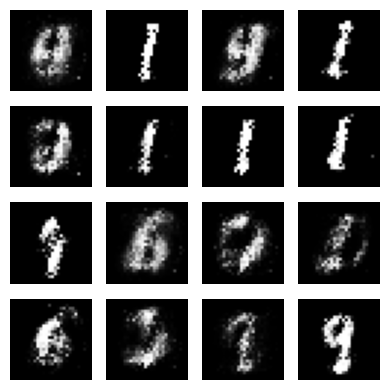

In [ ]:
#G = Generator(Z_dim, h_dim, X_dim).to(device)
#G.load_state_dict(torch.load("checkpoints/G_best.pth", map_location=device))
G.eval()                     # inference mode: disables dropout / batch-norm updates 5 epochs

# --- 3.  Generate images ---------------------------------------------
n_samples = 16               # how many images you want
with torch.no_grad():        # no gradients needed
    z = torch.randn(n_samples, Z_dim, device=device)
    samples = G(z).cpu().numpy()          # shape: (n_samples, 784)

# --- 4.  Visualise or save -------------------------------------------
fig, axes = plt.subplots(4, 4, figsize=(4,4))
axes = axes.flatten()
for img, ax in zip(samples, axes):
    ax.imshow(img.reshape(28,28), cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.savefig("generated_grid.png", dpi=150)
plt.show()

10 epochs

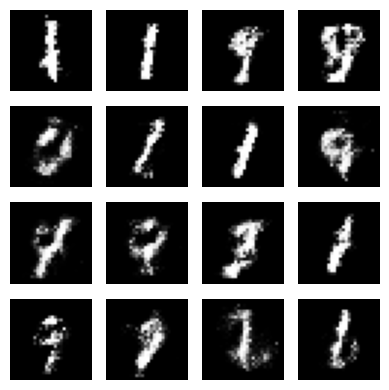

In [ ]:
#G = Generator(Z_dim, h_dim, X_dim).to(device)
#G.load_state_dict(torch.load("checkpoints/G_best.pth", map_location=device))
G.eval()                     # inference mode: disables dropout / batch-norm updates 10 epochs

# --- 3.  Generate images ---------------------------------------------
n_samples = 16               # how many images you want
with torch.no_grad():        # no gradients needed
    z = torch.randn(n_samples, Z_dim, device=device)
    samples = G(z).cpu().numpy()          # shape: (n_samples, 784)

# --- 4.  Visualise or save -------------------------------------------
fig, axes = plt.subplots(4, 4, figsize=(4,4))
axes = axes.flatten()
for img, ax in zip(samples, axes):
    ax.imshow(img.reshape(28,28), cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.savefig("generated_grid.png", dpi=150)
plt.show()

50 epochs

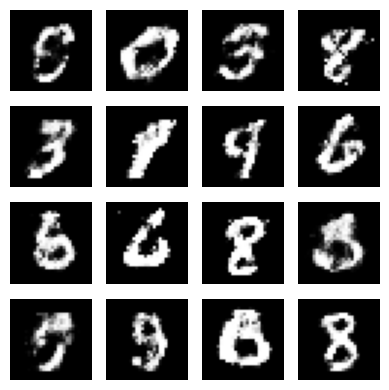

In [ ]:
#G = Generator(Z_dim, h_dim, X_dim).to(device)
#G.load_state_dict(torch.load("checkpoints/G_best.pth", map_location=device))
G.eval()                     # inference mode: disables dropout / batch-norm updates 50 epochs

# --- 3.  Generate images ---------------------------------------------
n_samples = 16               # how many images you want
with torch.no_grad():        # no gradients needed
    z = torch.randn(n_samples, Z_dim, device=device)
    samples = G(z).cpu().numpy()          # shape: (n_samples, 784)

# --- 4.  Visualise or save -------------------------------------------
fig, axes = plt.subplots(4, 4, figsize=(4,4))
axes = axes.flatten()
for img, ax in zip(samples, axes):
    ax.imshow(img.reshape(28,28), cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.savefig("generated_grid.png", dpi=150)
plt.show()

# Change to logistic loss

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import tqdm
import os
import wandb


# Hyperparameters
mb_size = 64
Z_dim = 1000
h_dim = 128 # Testa ändra hyperparams?
lr = 1e-3

# Load MNIST data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten the 28x28 image to 784
])

train_dataset = datasets.MNIST(root='../MNIST', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=mb_size, shuffle=True)

X_dim = 784  # 28 x 28

# Xavier Initialization
def xavier_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# Generator
class Generator(nn.Module):
    def __init__(self, z_dim, h_dim, x_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim, h_dim)
        self.fc2 = nn.Linear(h_dim, x_dim)
        self.apply(xavier_init)

    def forward(self, z):
        h = F.relu(self.fc1(z))
        out = torch.sigmoid(self.fc2(h))
        return out

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, x_dim, h_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(x_dim, h_dim)
        self.fc2 = nn.Linear(h_dim, 1)
        self.apply(xavier_init)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        out = self.fc2(h)
        return out



# Training
def cGANTraining(G, D, loss_fn, train_loader):
    G.train()
    D.train()

    D_loss_real_total = 0
    D_loss_fake_total = 0
    G_loss_total = 0
    t = tqdm.tqdm(train_loader)

    for it, (X_real, labels) in enumerate(t):
        # Prepare real data
        X_real = X_real.float().to(device)

        # Sample noise and labels
        z = torch.randn(X_real.size(0), Z_dim).to(device)
        ones_label = torch.ones(X_real.size(0), 1).to(device)
        zeros_label = torch.zeros(X_real.size(0), 1).to(device)

        # ================= Train Discriminator =================
        G_sample = G(z)
        D_real = D(X_real)
        D_fake = D(G_sample.detach())

        D_loss_real = loss_fn(D_real, ones_label)
        D_loss_fake = loss_fn(D_fake, zeros_label)
        D_loss = D_loss_real + D_loss_fake
        D_loss_real_total += D_loss_real.item()
        D_loss_fake_total += D_loss_fake.item()

        D_solver.zero_grad()
        D_loss.backward()
        D_solver.step()

        # ================= Train Generator ====================
        z = torch.randn(X_real.size(0), Z_dim).to(device)
        G_sample = G(z)
        D_fake = D(G_sample)

        G_loss = loss_fn(D_fake, ones_label)
        G_loss_total += G_loss.item()

        G_solver.zero_grad()
        G_loss.backward()
        G_solver.step()

    # ================= Logging =================
    D_loss_real_avg = D_loss_real_total / len(train_loader)
    D_loss_fake_avg = D_loss_fake_total / len(train_loader)
    D_loss_avg = D_loss_real_avg + D_loss_fake_avg
    G_loss_avg = G_loss_total / len(train_loader)

    wandb.log({
        "D_loss_real": D_loss_real_avg,
        "D_loss_fake": D_loss_fake_avg,
        "D_loss": D_loss_avg,
        "G_loss": G_loss_avg
    })

    return G, D, G_loss_avg, D_loss_avg



def save_sample(G, epoch, mb_size, Z_dim):
    out_dir = "out_vanila_GAN2"
    G.eval()
    with torch.no_grad():
        z = torch.randn(mb_size, Z_dim).to(device)
        samples = G(z).detach().cpu().numpy()[:16]

    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    if not os.path.exists(f'{out_dir}'):
        os.makedirs(f'{out_dir}')

    plt.savefig(f'{out_dir}/{str(epoch).zfill(3)}.png', bbox_inches='tight')
    plt.close(fig)



########################### Main #######################################
wandb_log = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Instantiate models
G = Generator(Z_dim, h_dim, X_dim).to(device)
D = Discriminator(X_dim, h_dim).to(device)

# Optimizers
G_solver = optim.Adam(G.parameters(), lr=lr)
D_solver = optim.Adam(D.parameters(), lr=lr)

# Loss function
# def my_bce_loss(preds, targets):
#     return F.binary_cross_entropy(preds, targets)

loss_fn = nn.BCEWithLogitsLoss()
# loss_fn = my_bce_loss

if wandb_log:
    wandb.init(project="conditional-gan-mnist")

    # Log hyperparameters
    wandb.config.update({
        "batch_size": mb_size,
        "Z_dim": Z_dim,
        "X_dim": X_dim,
        "h_dim": h_dim,
        "lr": lr,
    })

best_g_loss = float('inf')  # Initialize best generator loss
save_dir = 'checkpoints'
os.makedirs(save_dir, exist_ok=True)

#Train epochs
epochs = 50

for epoch in range(epochs):
    G, D, G_loss_avg, D_loss_avg= cGANTraining(G, D, loss_fn, train_loader)

    print(f'epoch{epoch}; D_loss: {D_loss_avg:.4f}; G_loss: {G_loss_avg:.4f}')

    if G_loss_avg < best_g_loss:
        best_g_loss = G_loss_avg
        torch.save(G.state_dict(), os.path.join(save_dir, 'G_best_log.pth'))
        torch.save(D.state_dict(), os.path.join(save_dir, 'D_best_log.pth'))
        print(f"Saved Best Models at epoch {epoch} | G_loss: {best_g_loss:.4f}")

    save_sample(G, epoch, mb_size, Z_dim)


# Inference
# G.load_state_dict(torch.load('checkpoints/G_best.pth'))
# G.eval()

# save_sample(G, "best", mb_size, Z_dim)

D_loss,▁▁▁▂▂▄▅▆▇█
D_loss_fake,▁▁▁▂▂▃▅▆▇█
D_loss_real,▂▁▁▂▃▄▅▆▇█
G_loss,█▇▇▆▆▅▃▂▁▁
D_loss,0.6296
D_loss_fake,0.28657
D_loss_real,0.34302
G_loss,3.29089


100%|██████████| 938/938 [00:11<00:00, 83.50it/s]


epoch0; D_loss: 0.0653; G_loss: 7.4382
Saved Best Models at epoch 0 | G_loss: 7.4382


100%|██████████| 938/938 [00:11<00:00, 81.97it/s]


epoch1; D_loss: 0.0208; G_loss: 7.9643


100%|██████████| 938/938 [00:11<00:00, 81.28it/s]


epoch2; D_loss: 0.0181; G_loss: 7.1412
Saved Best Models at epoch 2 | G_loss: 7.1412


100%|██████████| 938/938 [00:11<00:00, 79.97it/s]


epoch3; D_loss: 0.0247; G_loss: 6.5005
Saved Best Models at epoch 3 | G_loss: 6.5005


100%|██████████| 938/938 [00:11<00:00, 80.30it/s]


epoch4; D_loss: 0.0475; G_loss: 6.8512


100%|██████████| 938/938 [00:11<00:00, 81.53it/s]


epoch5; D_loss: 0.1040; G_loss: 5.8861
Saved Best Models at epoch 5 | G_loss: 5.8861


100%|██████████| 938/938 [00:11<00:00, 80.73it/s]


epoch6; D_loss: 0.1896; G_loss: 4.6848
Saved Best Models at epoch 6 | G_loss: 4.6848


100%|██████████| 938/938 [00:11<00:00, 81.61it/s]


epoch7; D_loss: 0.2809; G_loss: 4.3574
Saved Best Models at epoch 7 | G_loss: 4.3574


100%|██████████| 938/938 [00:11<00:00, 80.99it/s]


epoch8; D_loss: 0.4074; G_loss: 3.4460
Saved Best Models at epoch 8 | G_loss: 3.4460


100%|██████████| 938/938 [00:11<00:00, 81.08it/s]


epoch9; D_loss: 0.4532; G_loss: 3.2591
Saved Best Models at epoch 9 | G_loss: 3.2591


100%|██████████| 938/938 [00:11<00:00, 80.93it/s]


epoch10; D_loss: 0.5078; G_loss: 3.0604
Saved Best Models at epoch 10 | G_loss: 3.0604


100%|██████████| 938/938 [00:11<00:00, 80.33it/s]


epoch11; D_loss: 0.5463; G_loss: 2.8546
Saved Best Models at epoch 11 | G_loss: 2.8546


100%|██████████| 938/938 [00:11<00:00, 81.06it/s]


epoch12; D_loss: 0.5776; G_loss: 2.6660
Saved Best Models at epoch 12 | G_loss: 2.6660


100%|██████████| 938/938 [00:11<00:00, 82.76it/s]


epoch13; D_loss: 0.6086; G_loss: 2.5688
Saved Best Models at epoch 13 | G_loss: 2.5688


100%|██████████| 938/938 [00:11<00:00, 83.33it/s]


epoch14; D_loss: 0.6366; G_loss: 2.4138
Saved Best Models at epoch 14 | G_loss: 2.4138


100%|██████████| 938/938 [00:11<00:00, 83.11it/s]


epoch15; D_loss: 0.6417; G_loss: 2.3882
Saved Best Models at epoch 15 | G_loss: 2.3882


100%|██████████| 938/938 [00:11<00:00, 80.99it/s]


epoch16; D_loss: 0.6504; G_loss: 2.3043
Saved Best Models at epoch 16 | G_loss: 2.3043


100%|██████████| 938/938 [00:11<00:00, 81.42it/s]


epoch17; D_loss: 0.6625; G_loss: 2.2665
Saved Best Models at epoch 17 | G_loss: 2.2665


100%|██████████| 938/938 [00:11<00:00, 80.93it/s]


epoch18; D_loss: 0.6734; G_loss: 2.2246
Saved Best Models at epoch 18 | G_loss: 2.2246


100%|██████████| 938/938 [00:11<00:00, 81.19it/s]


epoch19; D_loss: 0.6781; G_loss: 2.2169
Saved Best Models at epoch 19 | G_loss: 2.2169


100%|██████████| 938/938 [00:11<00:00, 81.02it/s]


epoch20; D_loss: 0.6860; G_loss: 2.2481


100%|██████████| 938/938 [00:11<00:00, 80.33it/s]


epoch21; D_loss: 0.6786; G_loss: 2.2298


100%|██████████| 938/938 [00:11<00:00, 80.09it/s]


epoch22; D_loss: 0.6795; G_loss: 2.2356


100%|██████████| 938/938 [00:11<00:00, 79.60it/s]


epoch23; D_loss: 0.6708; G_loss: 2.2651


100%|██████████| 938/938 [00:11<00:00, 80.77it/s]


epoch24; D_loss: 0.6705; G_loss: 2.2459


100%|██████████| 938/938 [00:11<00:00, 81.22it/s]


epoch25; D_loss: 0.6508; G_loss: 2.3151


100%|██████████| 938/938 [00:11<00:00, 81.02it/s]


epoch26; D_loss: 0.6532; G_loss: 2.3646


100%|██████████| 938/938 [00:11<00:00, 83.89it/s]


epoch27; D_loss: 0.6446; G_loss: 2.3969


100%|██████████| 938/938 [00:11<00:00, 84.86it/s]


epoch28; D_loss: 0.6397; G_loss: 2.4223


100%|██████████| 938/938 [00:11<00:00, 82.60it/s]


epoch29; D_loss: 0.6357; G_loss: 2.4407


100%|██████████| 938/938 [00:11<00:00, 81.40it/s]


epoch30; D_loss: 0.6222; G_loss: 2.5029


100%|██████████| 938/938 [00:11<00:00, 80.64it/s]


epoch31; D_loss: 0.6199; G_loss: 2.5246


100%|██████████| 938/938 [00:11<00:00, 81.23it/s]


epoch32; D_loss: 0.6083; G_loss: 2.5490


100%|██████████| 938/938 [00:11<00:00, 81.39it/s]


epoch33; D_loss: 0.5994; G_loss: 2.6053


100%|██████████| 938/938 [00:11<00:00, 80.72it/s]


epoch34; D_loss: 0.5943; G_loss: 2.6260


100%|██████████| 938/938 [00:11<00:00, 81.57it/s]


epoch35; D_loss: 0.5884; G_loss: 2.6660


100%|██████████| 938/938 [00:11<00:00, 80.97it/s]


epoch36; D_loss: 0.5788; G_loss: 2.6648


100%|██████████| 938/938 [00:11<00:00, 81.24it/s]


epoch37; D_loss: 0.5608; G_loss: 2.7055


100%|██████████| 938/938 [00:11<00:00, 81.60it/s]


epoch38; D_loss: 0.5497; G_loss: 2.7392


100%|██████████| 938/938 [00:11<00:00, 81.10it/s]


epoch39; D_loss: 0.5429; G_loss: 2.8005


100%|██████████| 938/938 [00:11<00:00, 82.92it/s]


epoch40; D_loss: 0.5352; G_loss: 2.8035


100%|██████████| 938/938 [00:11<00:00, 84.70it/s]


epoch41; D_loss: 0.5307; G_loss: 2.8560


100%|██████████| 938/938 [00:11<00:00, 83.63it/s]


epoch42; D_loss: 0.5259; G_loss: 2.8095


100%|██████████| 938/938 [00:11<00:00, 82.43it/s]


epoch43; D_loss: 0.5163; G_loss: 2.8111


100%|██████████| 938/938 [00:11<00:00, 80.50it/s]


epoch44; D_loss: 0.5080; G_loss: 2.8373


100%|██████████| 938/938 [00:11<00:00, 81.50it/s]


epoch45; D_loss: 0.4992; G_loss: 2.8350


100%|██████████| 938/938 [00:11<00:00, 80.98it/s]


epoch46; D_loss: 0.4961; G_loss: 2.8657


100%|██████████| 938/938 [00:11<00:00, 80.46it/s]


epoch47; D_loss: 0.4859; G_loss: 2.8448


100%|██████████| 938/938 [00:11<00:00, 81.22it/s]


epoch48; D_loss: 0.4830; G_loss: 2.8539


100%|██████████| 938/938 [00:11<00:00, 80.65it/s]


epoch49; D_loss: 0.4776; G_loss: 2.8686


5 epochs

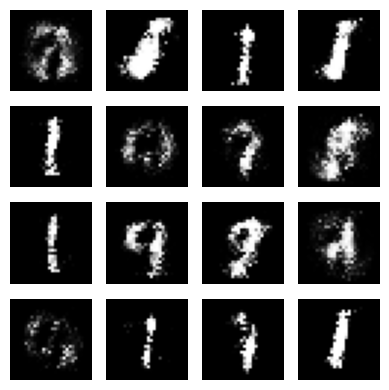

In [ ]:
#G = Generator(Z_dim, h_dim, X_dim).to(device)
#G.load_state_dict(torch.load("checkpoints/G_best_log.pth", map_location=device)) 5 epochs
G.eval()                     # inference mode: disables dropout / batch-norm updates

# --- 3.  Generate images ---------------------------------------------
n_samples = 16               # how many images you want
with torch.no_grad():        # no gradients needed
    z = torch.randn(n_samples, Z_dim, device=device)
    samples = G(z).cpu().numpy()          # shape: (n_samples, 784)

# --- 4.  Visualise or save -------------------------------------------
fig, axes = plt.subplots(4, 4, figsize=(4,4))
axes = axes.flatten()
for img, ax in zip(samples, axes):
    ax.imshow(img.reshape(28,28), cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.savefig("generated_grid.png", dpi=150)
plt.show()

10 epochs

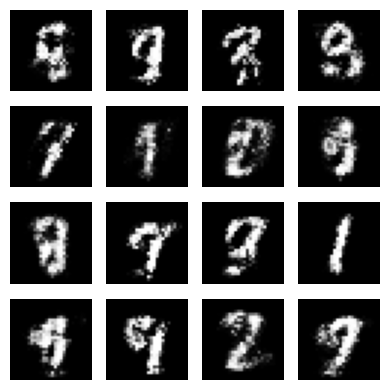

In [ ]:
#G = Generator(Z_dim, h_dim, X_dim).to(device)
#G.load_state_dict(torch.load("checkpoints/G_best_log.pth", map_location=device)) 10 epochs
G.eval()                     # inference mode: disables dropout / batch-norm updates

# --- 3.  Generate images ---------------------------------------------
n_samples = 16               # how many images you want
with torch.no_grad():        # no gradients needed
    z = torch.randn(n_samples, Z_dim, device=device)
    samples = G(z).cpu().numpy()          # shape: (n_samples, 784)

# --- 4.  Visualise or save -------------------------------------------
fig, axes = plt.subplots(4, 4, figsize=(4,4))
axes = axes.flatten()
for img, ax in zip(samples, axes):
    ax.imshow(img.reshape(28,28), cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.savefig("generated_grid.png", dpi=150)
plt.show()

50 epochs

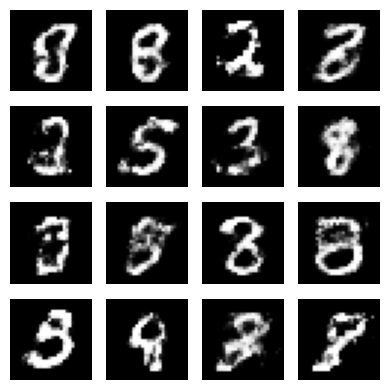

In [ ]:
#G = Generator(Z_dim, h_dim, X_dim).to(device)
#G.load_state_dict(torch.load("checkpoints/G_best_log.pth", map_location=device)) 50 epochs
G.eval()                     # inference mode: disables dropout / batch-norm updates

# --- 3.  Generate images ---------------------------------------------
n_samples = 16               # how many images you want
with torch.no_grad():        # no gradients needed
    z = torch.randn(n_samples, Z_dim, device=device)
    samples = G(z).cpu().numpy()          # shape: (n_samples, 784)

# --- 4.  Visualise or save -------------------------------------------
fig, axes = plt.subplots(4, 4, figsize=(4,4))
axes = axes.flatten()
for img, ax in zip(samples, axes):
    ax.imshow(img.reshape(28,28), cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.savefig("generated_grid.png", dpi=150)
plt.show()

# Task 3

In [1]:
# ================================================================
# Conditional (one-hot concat) GAN for MNIST – minimal diff version
# ================================================================

import os, tqdm, torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import wandb

# ----------------------- Hyper-parameters -----------------------
mb_size = 64
Z_dim   = 1000        # noise length
h_dim   = 128
y_dim   = 10          # number of classes (0-9)
lr      = 1e-3
epochs  = 50

# --------------------------- Dataset ----------------------------
transform = transforms.Compose([
    transforms.ToTensor(),                     # [0,1]
    transforms.Lambda(lambda x: x.view(-1))    # 28×28 → 784 flat
])

train_dataset = datasets.MNIST(
    root='../MNIST', train=True, transform=transform, download=True
)
train_loader  = DataLoader(train_dataset, batch_size=mb_size, shuffle=True)

X_dim = 784   # 28 × 28

# ------------------ Xavier / Glorot initialiser -----------------
def xavier_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# --------------------------- Generator --------------------------
class Generator(nn.Module):
    def __init__(self, z_dim, y_dim, h_dim, x_dim):
        super().__init__()
        self.fc1 = nn.Linear(z_dim + y_dim, h_dim)
        self.fc2 = nn.Linear(h_dim, x_dim)
        self.apply(xavier_init)

    def forward(self, z, y_onehot):
        z = torch.cat([z, y_onehot], dim=1)     # concat noise ⊕ label
        h = F.relu(self.fc1(z))
        return torch.sigmoid(self.fc2(h))       # pixels in [0,1]

# ------------------------- Discriminator ------------------------
class Discriminator(nn.Module):
    def __init__(self, x_dim, y_dim, h_dim):
        super().__init__()
        self.fc1 = nn.Linear(x_dim + y_dim, h_dim)
        self.fc2 = nn.Linear(h_dim, 1)
        self.apply(xavier_init)

    def forward(self, x, y_onehot):
        x = torch.cat([x, y_onehot], dim=1)     # concat image ⊕ label
        h = F.relu(self.fc1(x))
        return self.fc2(h)                      # raw logits

# --------------------------- Sampling ---------------------------
def save_sample(G, epoch, digit, n_samples=16):
    """
    Generate `n_samples` examples of the chosen `digit` (0-9) and save a 4×4 grid.
    """
    G.eval()
    out_dir = "out_cGAN"
    os.makedirs(out_dir, exist_ok=True)

    with torch.no_grad():
        z        = torch.randn(n_samples, Z_dim, device=device)
        y        = torch.full((n_samples,), digit, dtype=torch.long, device=device)
        y_onehot = F.one_hot(y, num_classes=y_dim).float()
        samples  = G(z, y_onehot).cpu().numpy()

    fig = plt.figure(figsize=(4, 4))
    gs  = gridspec.GridSpec(4, 4); gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i]); ax.axis('off')
        ax.imshow(sample.reshape(28, 28), cmap='Greys_r')

    plt.savefig(f"{out_dir}/{str(epoch).zfill(3)}_{digit}.png", bbox_inches='tight')
    plt.close(fig)

# --------------------------- Training ---------------------------
def train_cgan(G, D, loss_fn, loader):
    G.train(); D.train()

    D_real_tot = D_fake_tot = G_tot = 0

    for X_real, labels in tqdm.tqdm(loader, leave=False):
        X_real  = X_real.float().to(device)
        y_onehot = F.one_hot(labels, num_classes=y_dim).float().to(device)

        # ---------- Train Discriminator ----------
        z       = torch.randn(X_real.size(0), Z_dim, device=device)
        G_fake  = G(z, y_onehot)

        D_real  = D(X_real, y_onehot)
        D_fake  = D(G_fake.detach(), y_onehot)

        ones = torch.ones_like(D_real)
        zeros = torch.zeros_like(D_fake)

        D_loss_real = loss_fn(D_real,  ones)
        D_loss_fake = loss_fn(D_fake, zeros)
        D_loss      = D_loss_real + D_loss_fake

        D_solver.zero_grad()
        D_loss.backward()
        D_solver.step()

        # ---------- Train Generator -------------
        z       = torch.randn(X_real.size(0), Z_dim, device=device)
        G_fake  = G(z, y_onehot)
        D_fake  = D(G_fake, y_onehot)

        G_loss  = loss_fn(D_fake, ones)

        G_solver.zero_grad()
        G_loss.backward()
        G_solver.step()

        # ---------- Logs ------------------------
        D_real_tot += D_loss_real.item()
        D_fake_tot += D_loss_fake.item()
        G_tot      += G_loss.item()

    n_batches = len(loader)
    return (D_real_tot / n_batches,
            D_fake_tot / n_batches,
            G_tot      / n_batches)

# --------------------------- Main ------------------------------
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

G = Generator(Z_dim, y_dim, h_dim, X_dim).to(device)
D = Discriminator(X_dim, y_dim, h_dim).to(device)

G_solver = optim.Adam(G.parameters(), lr=lr)
D_solver = optim.Adam(D.parameters(), lr=lr)

loss_fn  = nn.BCEWithLogitsLoss()

# -------- WandB (optional) ----------
wandb.init(project="conditional-gan-mnist", config={
    "batch_size": mb_size, "Z_dim": Z_dim, "h_dim": h_dim, "lr": lr
})

best_g = float('inf'); os.makedirs('checkpoints', exist_ok=True)

for epoch in range(epochs):
    D_real, D_fake, G_loss = train_cgan(G, D, loss_fn, train_loader)
    D_loss = D_real + D_fake
    print(f"epoch {epoch:03d} | D_loss {D_loss:.4f} | G_loss {G_loss:.4f}")

    wandb.log({"epoch": epoch, "D_loss_real": D_real, "D_loss_fake": D_fake,
               "D_loss": D_loss, "G_loss": G_loss})

    if G_loss < best_g:
        best_g = G_loss
        torch.save(G.state_dict(), 'checkpoints/G_best_cGAN.pth')
        torch.save(D.state_dict(), 'checkpoints/D_best_cGAN.pth')

    # save a grid of e.g. digit '3' every epoch
    save_sample(G, epoch, digit=3)

print("Training complete.")


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.02MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.28MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.3MB/s]


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: kimjonas_ylivainio (kimjonas_ylivainio-lule-university-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


epoch 000 | D_loss 0.0667 | G_loss 6.4084


epoch 001 | D_loss 0.0248 | G_loss 6.9464


epoch 002 | D_loss 0.0384 | G_loss 6.0932


epoch 003 | D_loss 0.0797 | G_loss 6.0528


epoch 004 | D_loss 0.1297 | G_loss 5.4564


epoch 005 | D_loss 0.1961 | G_loss 5.2608


epoch 006 | D_loss 0.3267 | G_loss 4.5721


epoch 007 | D_loss 0.4462 | G_loss 3.9357


epoch 008 | D_loss 0.4895 | G_loss 3.6631


epoch 009 | D_loss 0.5350 | G_loss 3.4552


epoch 010 | D_loss 0.5965 | G_loss 3.0470


epoch 011 | D_loss 0.6327 | G_loss 2.9155


epoch 012 | D_loss 0.6610 | G_loss 2.7724


epoch 013 | D_loss 0.6935 | G_loss 2.6105


epoch 014 | D_loss 0.7208 | G_loss 2.4475


epoch 015 | D_loss 0.7171 | G_loss 2.3159


epoch 016 | D_loss 0.7286 | G_loss 2.1858


epoch 017 | D_loss 0.7281 | G_loss 2.1894


epoch 018 | D_loss 0.7327 | G_loss 2.1379


epoch 019 | D_loss 0.7306 | G_loss 2.1563


epoch 020 | D_loss 0.7366 | G_loss 2.1166


epoch 021 | D_loss 0.7370 | G_loss 2.1092


epoch 022 | D_loss 0.7416 | G_loss 2.0939


epoch 023 | D_loss 0.7379 | G_loss 2.0872


epoch 024 | D_loss 0.7375 | G_loss 2.1051


epoch 025 | D_loss 0.7322 | G_loss 2.0819


epoch 026 | D_loss 0.7383 | G_loss 2.1064


epoch 027 | D_loss 0.7371 | G_loss 2.1136


epoch 028 | D_loss 0.7293 | G_loss 2.1228


epoch 029 | D_loss 0.7236 | G_loss 2.1617


epoch 030 | D_loss 0.7177 | G_loss 2.1696


epoch 031 | D_loss 0.7106 | G_loss 2.1801


epoch 032 | D_loss 0.7085 | G_loss 2.1970


epoch 033 | D_loss 0.7102 | G_loss 2.2242


epoch 034 | D_loss 0.6954 | G_loss 2.2224


epoch 035 | D_loss 0.6907 | G_loss 2.2434


epoch 036 | D_loss 0.6897 | G_loss 2.2568


epoch 037 | D_loss 0.6836 | G_loss 2.2555


epoch 038 | D_loss 0.6844 | G_loss 2.2778


epoch 039 | D_loss 0.6764 | G_loss 2.2978


epoch 040 | D_loss 0.6755 | G_loss 2.3108


epoch 041 | D_loss 0.6675 | G_loss 2.3140


epoch 042 | D_loss 0.6658 | G_loss 2.3321


epoch 043 | D_loss 0.6644 | G_loss 2.3391


epoch 044 | D_loss 0.6590 | G_loss 2.3615


epoch 045 | D_loss 0.6589 | G_loss 2.3641


epoch 046 | D_loss 0.6562 | G_loss 2.3660


epoch 047 | D_loss 0.6553 | G_loss 2.3650


epoch 048 | D_loss 0.6544 | G_loss 2.3752


epoch 049 | D_loss 0.6493 | G_loss 2.3880
Training complete.


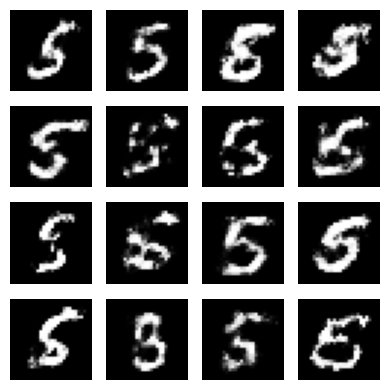

In [7]:
G = Generator(Z_dim, y_dim, h_dim, X_dim).to(device)

# ---------- 2.  Load the trained weights --------------------------
G.load_state_dict(torch.load("checkpoints/G_best_cGAN.pth",
                             map_location=device))
G.eval()                                         # inference mode

# ---------- 3.  Choose the digit you want -------------------------
digit      = 5            # 0-9  (change freely)
n_samples  = 16

z          = torch.randn(n_samples, Z_dim, device=device)
y          = torch.full((n_samples,), digit, dtype=torch.long, device=device)
y_onehot   = torch.nn.functional.one_hot(y, num_classes=y_dim).float()

with torch.no_grad():
    samples = G(z, y_onehot).cpu().numpy()       # (n_samples, 784)

# ---------- 4.  Visualise / save ----------------------------------
fig, axes = plt.subplots(4, 4, figsize=(4,4))
for img, ax in zip(samples, axes.flatten()):
    ax.imshow(img.reshape(28,28), cmap="gray"); ax.axis("off")

plt.tight_layout()
plt.savefig(f"cgan_digit_{digit}.png", dpi=150)
plt.show()

# Task 4

test accuracy: 98.570%


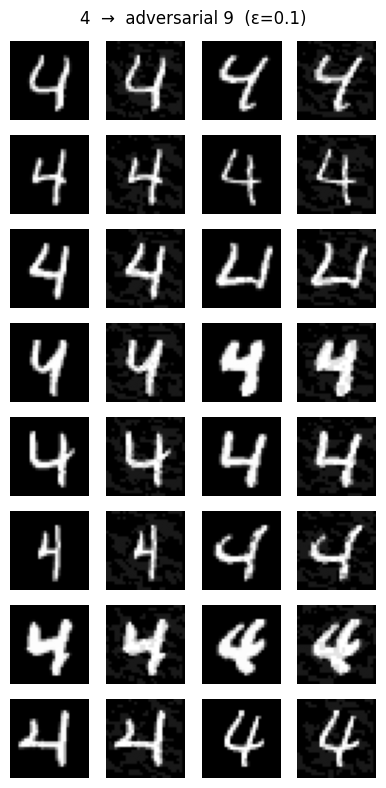

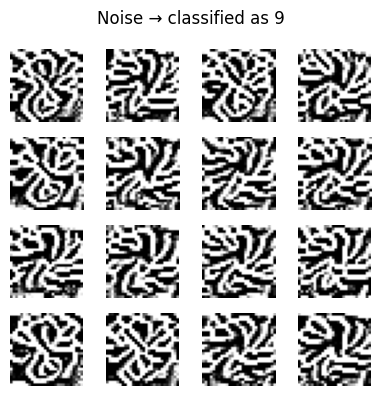

acc on unperturbed fours : 100%
acc on adversarial fours : 0%


In [2]:
# ================================================
# MNIST CNN + targeted FGSM adversarial examples
# ================================================
import torch, torch.nn as nn, torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt;  plt.style.use('default')
import math, matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ---------- 1.  Data ----------
tfm = transforms.Compose([transforms.ToTensor()])
train_set = datasets.MNIST('.', train=True , download=True, transform=tfm)
test_set  = datasets.MNIST('.', train=False, download=True, transform=tfm)
train_loader = DataLoader(train_set, 128, shuffle=True)
test_loader  = DataLoader(test_set , 1000)

# ---------- 2.  Model ----------
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1   = nn.Linear(64 * 12 * 12, 128)
        self.fc2   = nn.Linear(128, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)           # logits

net = SimpleCNN().to(device)
opt = torch.optim.Adam(net.parameters(), lr=1e-3)
ce  = nn.CrossEntropyLoss()

# ---------- 3.  Train (3 epochs is enough) ----------
for epoch in range(3):
    net.train()
    for x,y in train_loader:
        x,y = x.to(device), y.to(device)
        opt.zero_grad()
        ce(net(x), y).backward()
        opt.step()

# ---------- helper : accuracy ----------
def accuracy(model, loader):
    model.eval(); n=0; k=0
    with torch.no_grad():
        for x,y in loader:
            n += y.size(0)
            k += (model(x.to(device)).argmax(1).cpu()==y).sum().item()
    return k/n

print(f"test accuracy: {accuracy(net,test_loader):.3%}")

# ---------- 4.  Targeted FGSM  (4 -> 9) ----------
def fgsm_tgt(model, x, target_label, eps):
    """
    x            : (B, 1, 28, 28) input(s) with grad
    target_label : int or 1-D tensor, desired class
    eps          : L_inf step size
    """
    x_adv = x.clone().detach().to(device).requires_grad_(True)

    # ----- build a target tensor that matches batch size -----
    if isinstance(target_label, int):
        target = torch.full((x_adv.size(0),), target_label,
                            dtype=torch.long, device=device)
    else:                           # already a tensor of length B
        target = target_label.to(device)

    loss = ce(model(x_adv), target)   # cross-entropy
    loss.backward()

    x_adv = (x_adv + eps * x_adv.grad.sign()).clamp(0, 1).detach()
    return x_adv

eps = 0.1          # try 0.1 – 0.3
adv_images = []; originals = []
net.eval()
for x,y in test_loader:
    mask = (y==4)                       # pick all '4's
    if mask.any():
        x4 = x[mask][:16].to(device)    # first 16 fours
        for img in x4:
            adv = fgsm_tgt(net, img.unsqueeze(0), target_label=9, eps=eps)
            adv_images.append(adv.cpu())
            originals.append(img.cpu())
        break                           # 16 samples are enough

# ---------- 5.  Random-noise ➜ 9 ----------
noise_imgs   = torch.rand(16,1,28,28, device=device)
noise_imgs.requires_grad = True
for _ in range(40):                     # 40 FGSM iterations ≈ PGD
    adv = fgsm_tgt(net, noise_imgs, 9, eps=0.05)
    noise_imgs.data = adv               # iterate

# ---------- 6.  Visual compare ----------
def plot_grid(imgs, title, fname, n_cols=4):
    """
    Show/save a grid for an arbitrary number of images.
    n_cols = 4 keeps each row short; rows expand automatically.
    """
    n_imgs  = len(imgs)
    n_rows  = math.ceil(n_imgs / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(n_cols, n_rows))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        ax.axis("off")
        if i < n_imgs:                          # draw only existing images
            ax.imshow(imgs[i].squeeze(),
                      cmap="gray", vmin=0, vmax=1)

    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig(fname, dpi=150)
    plt.show()

plot_grid([i for pair in zip(originals,adv_images) for i in pair],
          "4  →  adversarial 9  (ε=0.1)", "adv_4_to_9.png")

plot_grid(noise_imgs.detach().cpu(),          #  ← add .detach()
          "Noise → classified as 9",
          "noise_to_9.png")

# ---------- 7.  Accuracy drop ----------
def adv_accuracy(model):
    wrong = 0; total=0
    for img in adv_images:
        pred = model(img.to(device)).argmax(1).item()
        wrong += (pred!=9)
        total += 1
    return 1 - wrong/total

# (a) un-perturbed 4-images
orig_batch = torch.stack(originals).to(device)        # (16,1,28,28)
with torch.no_grad():
    preds_orig = net(orig_batch).argmax(1).cpu()
acc_orig = (preds_orig == 4).float().mean().item()    # fraction correct

# (b) adversarial 4 → 9 images
def adv_accuracy(model):
    batch = torch.cat(adv_images).to(device)          # (16,1,28,28)
    with torch.no_grad():
        preds = model(batch).argmax(1).cpu()
    return (preds == 9).float().mean().item()

print(f"acc on unperturbed fours : {acc_orig:.0%}")
print(f"acc on adversarial fours : {adv_accuracy(net):.0%}")


# Task 5

<ipython-input-17-43a2fc565404>:143: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None
epoch 0:   0%|          | 0/468 [00:00<?, ?it/s]<ipython-input-17-43a2fc565404>:168: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
epoch 0: 100%|██████████| 468/468 [00:34<00:00, 13.50it/s, loss=0.0545]


[epoch 0] avg L=0.1230


epoch 1: 100%|██████████| 468/468 [00:34<00:00, 13.52it/s, loss=0.0497]


[epoch 1] avg L=0.0521


epoch 2: 100%|██████████| 468/468 [00:34<00:00, 13.52it/s, loss=0.0414]


[epoch 2] avg L=0.0479


epoch 3: 100%|██████████| 468/468 [00:34<00:00, 13.50it/s, loss=0.0531]


[epoch 3] avg L=0.0458


epoch 4: 100%|██████████| 468/468 [00:34<00:00, 13.61it/s, loss=0.0487]


[epoch 4] avg L=0.0443


epoch 5: 100%|██████████| 468/468 [00:34<00:00, 13.56it/s, loss=0.0448]


[epoch 5] avg L=0.0445


epoch 6: 100%|██████████| 468/468 [00:34<00:00, 13.59it/s, loss=0.0420]


[epoch 6] avg L=0.0440


epoch 7: 100%|██████████| 468/468 [00:34<00:00, 13.62it/s, loss=0.0433]


[epoch 7] avg L=0.0428


epoch 8: 100%|██████████| 468/468 [00:34<00:00, 13.49it/s, loss=0.0479]


[epoch 8] avg L=0.0426


epoch 9: 100%|██████████| 468/468 [00:34<00:00, 13.53it/s, loss=0.0371]


[epoch 9] avg L=0.0422


epoch 10: 100%|██████████| 468/468 [00:34<00:00, 13.59it/s, loss=0.0356]


[epoch 10] avg L=0.0422


epoch 11: 100%|██████████| 468/468 [00:34<00:00, 13.49it/s, loss=0.0387]


[epoch 11] avg L=0.0418


epoch 12: 100%|██████████| 468/468 [00:34<00:00, 13.53it/s, loss=0.0385]


[epoch 12] avg L=0.0415


epoch 13: 100%|██████████| 468/468 [00:34<00:00, 13.45it/s, loss=0.0498]


[epoch 13] avg L=0.0414


epoch 14: 100%|██████████| 468/468 [00:34<00:00, 13.50it/s, loss=0.0442]


[epoch 14] avg L=0.0411


epoch 15: 100%|██████████| 468/468 [00:34<00:00, 13.58it/s, loss=0.0348]


[epoch 15] avg L=0.0397


epoch 16: 100%|██████████| 468/468 [00:34<00:00, 13.59it/s, loss=0.0349]


[epoch 16] avg L=0.0397


epoch 17: 100%|██████████| 468/468 [00:34<00:00, 13.59it/s, loss=0.0471]


[epoch 17] avg L=0.0392


epoch 18: 100%|██████████| 468/468 [00:34<00:00, 13.57it/s, loss=0.0337]


[epoch 18] avg L=0.0395


epoch 19: 100%|██████████| 468/468 [00:34<00:00, 13.48it/s, loss=0.0416]


[epoch 19] avg L=0.0396


epoch 20: 100%|██████████| 468/468 [00:34<00:00, 13.54it/s, loss=0.0322]


[epoch 20] avg L=0.0392


epoch 21: 100%|██████████| 468/468 [00:34<00:00, 13.57it/s, loss=0.0422]


[epoch 21] avg L=0.0389


epoch 22: 100%|██████████| 468/468 [00:34<00:00, 13.46it/s, loss=0.0411]


[epoch 22] avg L=0.0391


epoch 23: 100%|██████████| 468/468 [00:34<00:00, 13.52it/s, loss=0.0398]


[epoch 23] avg L=0.0396


epoch 24: 100%|██████████| 468/468 [00:34<00:00, 13.56it/s, loss=0.0341]


[epoch 24] avg L=0.0394


epoch 25: 100%|██████████| 468/468 [00:34<00:00, 13.54it/s, loss=0.0465]


[epoch 25] avg L=0.0392


epoch 26: 100%|██████████| 468/468 [00:34<00:00, 13.68it/s, loss=0.0448]


[epoch 26] avg L=0.0389


epoch 27: 100%|██████████| 468/468 [00:34<00:00, 13.62it/s, loss=0.0329]


[epoch 27] avg L=0.0390


epoch 28: 100%|██████████| 468/468 [00:34<00:00, 13.51it/s, loss=0.0416]


[epoch 28] avg L=0.0390


epoch 29: 100%|██████████| 468/468 [00:34<00:00, 13.50it/s, loss=0.0349]


[epoch 29] avg L=0.0388


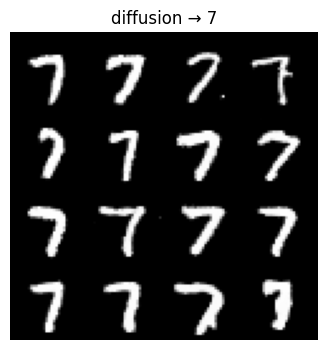

In [17]:
import torch, torch.nn as nn, torch.nn.functional as F
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt, math, os, tqdm

# ----------------- 0.  Setup & flags ---------------------------
device   = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
use_amp  = True                     # FP16 if available
save_dir = "mnist_ddpm_fixed"; os.makedirs(save_dir, exist_ok=True)

# ----------------- 1.  Data -----------------------------------
tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x*2. - 1.)          # scale to [-1,1]
])
ds  = datasets.MNIST('.', train=True, download=True, transform=tfm)
loader = DataLoader(ds, 128, shuffle=True, drop_last=True)

# ----------------- 2.  Cosine β schedule ----------------------
T = 1000
def cosine_beta_schedule(timesteps, s=0.008):
    steps = torch.arange(timesteps+1, dtype=torch.float32)
    ab = torch.cos(((steps/timesteps)+s)/(1+s) * math.pi/2) ** 2
    ab = ab / ab[0]
    betas = 1 - (ab[1:] / ab[:-1])
    return torch.clip(betas, 1e-5, 0.999)

beta  = cosine_beta_schedule(T).to(device)
alpha = 1.0 - beta
alpha_bar = torch.cat([
    torch.ones(1, device=device),
    alpha.cumprod(0)[:-1]
])
sqrt_ab   = torch.sqrt(alpha_bar)
sqrt_1mab = torch.sqrt(1 - alpha_bar)

# ----------------- 3.  U‑Net ----------------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F

def conv3x3(in_c, out_c):
    return nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)

class ResidualBlock(nn.Module):
    def __init__(self, in_c, out_c, emb_c, num_groups=8):
        super().__init__()
        # adjust groups so they divide num_channels
        g1 = num_groups if in_c  % num_groups == 0 else min(num_groups, in_c)
        g2 = num_groups if out_c % num_groups == 0 else min(num_groups, out_c)
        self.norm1 = nn.GroupNorm(g1, in_c)
        self.conv1 = conv3x3(in_c, out_c)
        self.norm2 = nn.GroupNorm(g2, out_c)
        self.conv2 = conv3x3(out_c, out_c)
        self.emb   = nn.Linear(emb_c, out_c)
        self.res_conv = nn.Conv2d(in_c, out_c, 1) if in_c != out_c else nn.Identity()

    def forward(self, x, t_emb):
        h = F.silu(self.norm1(x))
        h = self.conv1(h)
        h = F.silu(self.norm2(h))
        h = self.conv2(h)

        # time+class embedding -> add and residual
        emb_out = self.emb(t_emb)[..., None, None]
        return h + emb_out + self.res_conv(x)

class LargerUNet(nn.Module):
    def __init__(self, emb_dim=128, base_c=64):
        super().__init__()
        # time & label embeddings (hard-coded 10 classes)
        self.time_embed  = nn.Sequential(
            nn.Linear(emb_dim, emb_dim*4),
            nn.SiLU(),
            nn.Linear(emb_dim*4, emb_dim)
        )
        self.label_embed = nn.Embedding(10, emb_dim)

        # encoder: 28→14→7
        self.enc1 = ResidualBlock(1,      base_c,      emb_dim)
        self.enc2 = ResidualBlock(base_c, base_c*2,    emb_dim)
        self.enc3 = ResidualBlock(base_c*2, base_c*4,  emb_dim)
        self.pool = nn.MaxPool2d(2)

        # bottleneck at 7×7
        self.bottleneck = ResidualBlock(base_c*4, base_c*4, emb_dim)

        # decoder: 7→14→28
        self.up3 = ResidualBlock(base_c*4 + base_c*4, base_c*2, emb_dim)
        self.up2 = ResidualBlock(base_c*2 + base_c*2, base_c,   emb_dim)
        self.up1 = ResidualBlock(base_c   + base_c,     base_c,   emb_dim)

        # output to 1 channel
        self.conv_out = nn.Conv2d(base_c, 1, kernel_size=1)

    def forward(self, x, t, y):
        # 1) build time+class embedding
        #    positional encoding
        half = self.time_embed[0].in_features // 2
        inv  = 1.0 / (10000 ** (torch.arange(half, device=x.device) / half))
        s    = torch.outer(t.float(), inv)
        t_emb= torch.cat([s.sin(), s.cos()], dim=-1)
        t_emb= self.time_embed(t_emb)
        y_emb= self.label_embed(y)
        emb  = t_emb + y_emb

        # 2) encode
        e1 = self.enc1(x, emb)               # 28×28
        e2 = self.enc2(self.pool(e1), emb)   # 14×14
        e3 = self.enc3(self.pool(e2), emb)   # 7×7

        # 3) bottleneck (no further pool)
        b = self.bottleneck(e3, emb)         # 7×7

        # 4) decode with exact spatial matches
        d3 = F.interpolate(b, size=e3.shape[2:], mode='nearest')  # →7×7
        d3 = self.up3(torch.cat([d3, e3], dim=1), emb)

        d2 = F.interpolate(d3, size=e2.shape[2:], mode='nearest') # →14×14
        d2 = self.up2(torch.cat([d2, e2], dim=1), emb)

        d1_in = F.interpolate(d2, size=e1.shape[2:], mode='nearest') # →28×28
        d1    = self.up1(torch.cat([d1_in, e1], dim=1), emb)

        return self.conv_out(d1)

    @staticmethod
    def pos_enc(t, dim):
        # (not used directly; inline in forward)
        pass



# ----------------- 4.  Model / EMA / Opt / Sched ---------------
model = LargerUNet().to(device)
ema   = LargerUNet().to(device); ema.load_state_dict(model.state_dict())
opt   = torch.optim.Adam(model.parameters(), lr=5e-4)  # lowered LR
sched = torch.optim.lr_scheduler.StepLR(opt, step_size=15, gamma=0.5)
scaler = torch.cuda.amp.GradScaler() if use_amp else None

def ema_step(src, tgt, d=0.999):
    with torch.no_grad():
        for p, q in zip(tgt.parameters(), src.parameters()):
            p.data.mul_(d).add_(q.data * (1-d))

# ----------------- 5.  Forward diffusion -----------------------
def q_sample(x0, t, noise):
    return sqrt_ab[t][:,None,None,None]*x0 + \
           sqrt_1mab[t][:,None,None,None]*noise

# ----------------- 6.  Training loop ---------------------------
epochs = 30  # more epochs
for epoch in range(epochs):
    tot_L, n_batches = 0.0, 0
    pbar = tqdm.tqdm(loader, desc=f"epoch {epoch}")
    for x, y in pbar:
        x, y = x.to(device), y.to(device)
        t = torch.randint(0, T, (x.size(0),), device=device).long()
        noise = torch.randn_like(x)
        x_t   = q_sample(x, t, noise)

        # using unweighted MSE as loss (simplified objective)
        if use_amp:
            with torch.cuda.amp.autocast():
                pred = model(x_t, t, y)
                loss = F.mse_loss(pred, noise)
            opt.zero_grad()
            scaler.scale(loss).backward()
            scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(opt); scaler.update()
        else:
            pred = model(x_t, t, y)
            loss = F.mse_loss(pred, noise)
            opt.zero_grad(); loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

        ema_step(model, ema)
        tot_L += loss.item(); n_batches += 1
        pbar.set_postfix(loss=f"{loss.item():.4f}")

    print(f"[epoch {epoch}] avg L={tot_L/n_batches:.4f}")
    sched.step()
    torch.save(ema.state_dict(), f"{save_dir}/ema_{epoch}.pth")

# ----------------- 7.  Deterministic DDIM-20 Sampler ---------  Deterministic DDIM‑20 Sampler ---------

ddim_steps = 50
raw = torch.linspace(0, T-1, ddim_steps, device=device)
indices = raw.round().long().flip(0)

@torch.no_grad()
def sample_digit(net, digit, n=16):
    net.eval()
    y = torch.full((n,), digit, dtype=torch.long, device=device)
    x = torch.randn(n,1,28,28, device=device)

    for i, t_ in enumerate(indices):
        t = torch.full((n,), int(t_), device=device)
        eps = net(x, t, y)
        a_bar = alpha_bar[t][:,None,None,None]
        x0 = (x - torch.sqrt(1 - a_bar) * eps) / torch.sqrt(a_bar)

        if i < len(indices)-1:
            a_bar_n = alpha_bar[int(indices[i+1])]
            x = (a_bar_n.sqrt() * x0
                + (1 - a_bar_n).sqrt() * eps)
        else:
            x = x0

    return x.clamp(-1,1)

# ----------------- 8.  Visual test ------------------------------
digit = 7
samples = sample_digit(ema, digit=7, n=16)
grid = utils.make_grid((samples + 1) / 2, nrow=4)
plt.figure(figsize=(4,4)); plt.axis('off'); plt.title(f'diffusion → {digit}')
plt.imshow(grid.permute(1,2,0).cpu(), cmap='gray')
plt.savefig(f"{save_dir}/digit_{digit}_grid.png", dpi=150)
plt.show()




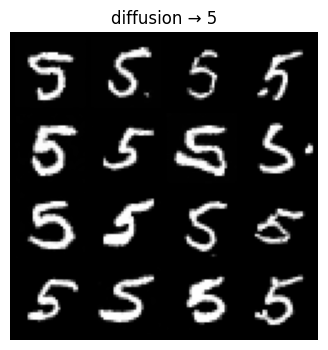

In [22]:
# ----------------- 7.  Deterministic DDIM-20 Sampler ---------  Deterministic DDIM‑20 Sampler ---------

ddim_steps = 1000
raw = torch.linspace(0, T-1, ddim_steps, device=device)
indices = raw.round().long().flip(0)

@torch.no_grad()
def sample_digit(net, digit, n=16):
    net.eval()
    y = torch.full((n,), digit, dtype=torch.long, device=device)
    x = torch.randn(n,1,28,28, device=device)

    for i, t_ in enumerate(indices):
        t = torch.full((n,), int(t_), device=device)
        eps = net(x, t, y)
        a_bar = alpha_bar[t][:,None,None,None]
        x0 = (x - torch.sqrt(1 - a_bar) * eps) / torch.sqrt(a_bar)

        if i < len(indices)-1:
            a_bar_n = alpha_bar[int(indices[i+1])]
            x = (a_bar_n.sqrt() * x0
                + (1 - a_bar_n).sqrt() * eps)
        else:
            x = x0

    return x.clamp(-1,1)

# ----------------- 8.  Visual test ------------------------------
digit = 5
samples = sample_digit(ema, digit, n=16)

grid = utils.make_grid((samples + 1) / 2, nrow=4)
plt.figure(figsize=(4,4)); plt.axis('off'); plt.title(f'diffusion → {digit}')
plt.imshow(grid.permute(1,2,0).cpu(), cmap='gray')
plt.savefig(f"{save_dir}/digit_{digit}_grid.png", dpi=150)
plt.show()

# Main difference between GAN and Stable diffusion
GAN consists of two networks, a generator and a discriminator, each competing in a minimax game. The generator learns to map a vector to a an image in a one shot manner and the discriminator learns to tell real from fake. In contrast, Diffusion-based models learn to denoise progressively noisier images of real images. In these networks there are no discriminator, instead the netowrk learns to reverse a known noise process. Instead of generating the image in a one shot manner, the stable diffusion process runs dozens of iterative denoising steps to reach the final output image, which is similar to the hopfield model in a way.

Summary:
GANs learn via a discriminator to directly map noise → image in one shot.

Stable Diffusion (and diffusion models generally) learn to iteratively denoise noisy images back to clean ones, trained with a simple regression loss—then invert that process to generate samples


How the diffusion process works:
**7. Putting the Pieces Together**

1. **Forward diffusion** (training):  
   $$
   x_t \;=\; \sqrt{\bar\alpha_t}\,x_0 \;+\; \sqrt{1 - \bar\alpha_t}\,\epsilon,
   \quad
   \epsilon \sim \mathcal{N}(0, I)
   $$

2. **Network objective** (simplified MSE loss):  
   $$
   \mathcal{L}(\theta)
   \;=\;
   \mathbb{E}_{t, x_0, \epsilon}\bigl[\|\epsilon - \epsilon_\theta(x_t, t, y)\|^2\bigr]
   $$

3. **EMA update** for inference weights:  
   $$
   \theta_{\mathrm{EMA}}
   \;\leftarrow\;
   \lambda\,\theta_{\mathrm{EMA}}
   \;+\;
   (1 - \lambda)\,\theta
   $$

4. **Reverse (sampling) step** (DDIM, $\sigma=0$):  
   $$
   x_{t-1}
   \;=\;
   \sqrt{\bar\alpha_{t-1}}\,x_0
   \;+\;
   \sqrt{1 - \bar\alpha_{t-1}}\,\epsilon_\theta(x_t, t, y),
   $$
   then iterate $t = T, T-1, \dots, 1$.

---

### Definitions of all variables

- $x_0$  
  The original (clean) image from the dataset.

- $x_t$  
  The noisy image at timestep $t$.

- $t$  
  Discrete timestep index, $t\in\{1,2,\dots,T\}$, usually sampled uniformly during training.

- $T$  
  Total number of diffusion steps (e.g.\ $T=1000$).

- $\epsilon$  
  A random Gaussian noise vector, $\epsilon \sim \mathcal{N}(0,I)$.

- $\epsilon_\theta(x_t, t, y)$  
  The U-Net’s prediction of the noise at step $t$, conditioned on noisy image $x_t$ and class label $y$.

- $\bar\alpha_t$  
  Cumulative product of the “signal” coefficients:  
  $\displaystyle \bar\alpha_t = \prod_{s=1}^t (1 - \beta_s)$.

- $\beta_t$  
  Variance schedule controlling how much noise to add at each forward step.

- $\theta$  
  The parameters (weights) of the neural network you train.

- $\theta_{\mathrm{EMA}}$  
  The exponential moving-average of $\theta$, used at sampling time for more stable outputs.

- $\lambda$  
  EMA decay rate (e.g.\ $0.999$), so that  
  $\theta_{\mathrm{EMA}} \leftarrow \lambda\,\theta_{\mathrm{EMA}} + (1-\lambda)\,\theta$.

- $y$  
  The class label (here $0,1,\dots,9$ for MNIST) used for conditional generation.

- $\mathcal{L}(\theta)$  
  The mean-squared error loss between the true noise $\epsilon$ and the model’s prediction.

- $\sigma$  
  The stochasticity parameter in DDIM; setting $\sigma=0$ yields the deterministic sampler shown above.


